In [21]:
from finance_analysis import FinancialInstrument as fi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

class Stock_Dataset(fi):
    def __init__(self,windows: list,horizons: list,intercross: bool,lookover: bool,**kwargs):
        """
        This class creates multiple datasets with varying windows and varying horizons so that multiple datasets
        can be created quickly.
        :param windows: List of windows to be produced. i.e if window is 7 then number of prices in X would be 7
        :param horizons: List of horizons to be produced. i.e. if horizon is 1 then Y will have price movement for 1 day.
        :param intercross: if true: eg. if windows = [5,7] and horizon = [2,3] then dataset produced would have
        [(5,2),(5,3),(7,2),(7,3)] windows and horizon pair respectively.
        else: the window horizon pair would be [(5,2),(7,3)]
        :param lookover: if true then single day windows would have prices for that day only not for the previous day where as otherwise
        they would have prices from previous day too. It is specifically for intra-day trading where we might not want previous day's prices to
        affect the model.
        :param kwargs: keyword arguments for Financial Instrument class which are ticker, start, end and interval specifically.
        """
        super().__init__(**kwargs)
        self.windows = windows
        self.horizons = horizons
        self.lookover = lookover
        self.intercross = intercross

    def create_dataset(self):
        self.dataset = {}
        if self.intercross:
            wh_list = list(product(self.windows,self.horizons))
        else:
            wh_list = [(i,j) for i,j in zip(self.windows,self.horizons)]

        for (i,j) in wh_list:
            tmp_dataset = self.create_windows_horizons(i,j)
            self.dataset[f'data_{i}_{j}'] = tmp_dataset


    def w_h(self,data,window,horizon):
        data['position'] = np.log(data.price / data.price.shift(horizon)).apply(lambda x: 1 if x>=0 else -1)
        data.dropna(inplace=True)
        for i in range(1,window+1):
            col = f't-{i}'
            data[col] = data.log_returns.shift(i)

        data.dropna(inplace=True)
        return data.copy()

    def create_windows_horizons(self,window,horizon):
        if self.lookover:
            grp = self.data.groupby(pd.Grouper(freq='D'))
            data_f = None
            for (t,val) in grp:
                val_2 = val.copy()
                tmp_data = self.w_h(val_2,window,horizon)
                if data_f is None:
                    data_f = tmp_data
                else:
                    data_f = pd.concat([data_f,tmp_data])

        else:
            data_f = self.w_h(self.data.copy(),window,horizon)

        return data_f



In [46]:
tata_data = Stock_Dataset(windows=[10],horizons=[3],intercross=False,lookover=False,ticker='TATAMOTORS.NS',start='2018-01-01',end=pd.Timestamp.today(),interval='1D')

[*********************100%***********************]  1 of 1 completed


In [22]:
infy_data = Stock_Dataset(windows=[10],horizons=[3],intercross=False,lookover=False,ticker='INFY.NS',start='2018-01-01',end=pd.Timestamp.today(),interval='1D')

[*********************100%***********************]  1 of 1 completed


In [97]:
tata_data.create_dataset()

In [103]:
tata_data.dataset['data_10_3'].position.head()

Date
2018-01-16 00:00:00+05:30   -1
2018-01-17 00:00:00+05:30   -1
2018-01-18 00:00:00+05:30   -1
2018-01-19 00:00:00+05:30    1
2018-01-22 00:00:00+05:30    1
Name: position, dtype: int64

In [104]:
tata_data.dataset['data_10_3'].position.value_counts()

-1    642
 1    627
Name: position, dtype: int64

In [44]:
np.log(infy_data.data.price / infy_data.data.price.shift(3)).dropna().iloc[::3].apply(lambda x: x if x>=0 else 0).sum()

5.303444152856573

In [58]:
np.log(tata_data.data.price / tata_data.data.price.shift(3)).dropna().iloc[::3] #.apply(lambda x: x if x>=0 else 0).sum()

Date
2018-01-04 00:00:00+05:30    0.012875
2018-01-09 00:00:00+05:30    0.017522
2018-01-12 00:00:00+05:30   -0.001029
2018-01-17 00:00:00+05:30   -0.032908
2018-01-22 00:00:00+05:30   -0.002486
                               ...   
2023-02-14 00:00:00+05:30    0.008663
2023-02-17 00:00:00+05:30   -0.001477
2023-02-22 00:00:00+05:30   -0.024042
2023-02-27 00:00:00+05:30   -0.027144
2023-03-02 00:00:00+05:30    0.005964
Name: price, Length: 426, dtype: float64

In [89]:
resampled_first = infy_data.data.price.resample('3D').first()
resampled_last = infy_data.data.price.iloc[2:].resample('3D').first()
resampled_mid = infy_data.data.price.iloc[1:].resample('3D').first()
funct = (lambda x: x if x>=0 else 0)
log_1 = np.log(resampled_first / resampled_first.shift(1))
log_2 = np.log(resampled_mid/ resampled_mid.shift(1))
log_3 = np.log(resampled_last / resampled_last.shift(1))
print(log.apply(funct).sum())
print(log_2.apply(funct).sum())
print(log_3.apply(funct).sum())

8.931071044530674
6.030765331238655
5.873857402438013


In [85]:
resampled_last

Date
2018-01-03 00:00:00+05:30    433.899994
2018-01-06 00:00:00+05:30    433.549988
2018-01-09 00:00:00+05:30    437.549988
2018-01-12 00:00:00+05:30    437.100006
2018-01-15 00:00:00+05:30    432.350006
                                ...    
2023-02-18 00:00:00+05:30    443.000000
2023-02-21 00:00:00+05:30    436.500000
2023-02-24 00:00:00+05:30    427.750000
2023-02-27 00:00:00+05:30    417.950012
2023-03-02 00:00:00+05:30    420.450012
Freq: 3D, Name: price, Length: 629, dtype: float64

In [72]:
print(tata_data.data.price.shift(3).iloc[::3].head())

Date
2018-01-01 00:00:00+05:30           NaN
2018-01-04 00:00:00+05:30    424.450012
2018-01-09 00:00:00+05:30    429.950012
2018-01-12 00:00:00+05:30    437.549988
2018-01-17 00:00:00+05:30    437.100006
Name: price, dtype: float64


In [90]:
tata_data.data.price.diff(1).apply(lambda x: x if x>=0 else 0).sum()

3348.3999633789062

In [92]:
tata_data.data.price[0]

424.45001220703125

In [93]:
3348/424

7.89622641509434

In [49]:
from finance_analysis import FinancialInstrument as fi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

class Stock_Dataset(fi):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.dataset = None

    def create_dataset(self,qty=3,window=None,horizon=None):
        self.window = window
        self.horizon = horizon
        self.qty=qty
        signal_dict = {}
        for i in range(len(self.data)-self.horizon):
            price_on_day = self.data.price[i]
            for j in range(1,self.horizon+1):
                if f't+{j}' not in signal_dict.keys():
                    signal_dict[f't+{j}'] = []
                f_price = self.data.price.iloc[i+j]
                turnover = self.qty*(f_price+price_on_day)
                stt = round(0.1*turnover/100)
                txn_nse = round(0.00345*turnover/100,2)
                gst = round(18/100*txn_nse,2)
                stamp = round(0.015/100*qty*self.data.price.iloc[i])
                dp = 15.94
                tax = stt+txn_nse+gst+stamp+dp
                s_pnl = f_price - price_on_day
                if s_pnl>0:
                    pnl = s_pnl-tax
                    if pnl>0:
                        signal_dict[f't+{j}'].append(1)
                    else:
                        signal_dict[f't+{j}'].append(0)
                else:
                    pnl = s_pnl + tax
                    if pnl>0:
                        signal_dict[f't+{j}'].append(0)
                    else:
                        signal_dict[f't+{j}'].append(-1)


        for i in signal_dict.keys():
            self.data[i] = signal_dict[i]+[None]*self.horizon

        for i in range(1,self.window):
            self.data[f't-{i}'] = self.data.log_returns.shift(i)

        key_ls = []
        for k in range(-self.window+1,self.horizon+1):
            if k==0:
                key = 'log_returns'
            else:
                key = f't+{k}' if k>0 else f't{k}'
            key_ls.append(key)

        self.data[key_ls].dropna(inplace=True)

        new_targets = []
        target_ls = [f't+{i}' for i in range(1,self.horizon+1)]
        target_array = self.data[target_ls].to_numpy().astype(np.int32)
        for i in target_array:
            n_zero = 0
            for j in i:
                if j!=0:
                    n_zero=1
                    new_targets.append(j)
                    break
            if n_zero==0:
                new_targets.append(0)
        self.data['final_targets'] = new_targets

        key_ls = ['price'] + key_ls + ['final_targets']
        self.dataset = self.data[key_ls].dropna().copy()
        return self.dataset


In [51]:
tata_stock = Stock_Dataset(ticker='TATAMOTORS.NS',start='2011-01-01',end=pd.Timestamp.today(),interval='1D')

[*********************100%***********************]  1 of 1 completed


In [55]:
tata_ds = tata_stock.create_dataset(qty=3,window=20,horizon=10)

/tmp/ipykernel_6804/271236298.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[key_ls].dropna(inplace=True)


In [56]:
tata_ds.final_targets.value_counts()

 0    1055
 1     971
-1     961
Name: final_targets, dtype: int64

In [34]:
target_ls = [f't+{i}' for i in range(1,8)]
target_array = tata_ds[target_ls].to_numpy().astype(np.int32)

In [35]:
new_targets = []
for i in target_array:
    n_zero = 0
    for j in i:
        if j!=0:
            n_zero=1
            new_targets.append(j)
            break
    if n_zero==0:
        new_targets.append(0)

In [18]:
target_s = pd.Series(new_targets)

In [19]:
target_s.head()

0    1
1    0
2    0
3    1
4    1
dtype: int64

In [20]:
target_s.value_counts()

 0    1517
 1     736
-1     736
dtype: int64

In [37]:
len(tata_ds)

2989

In [38]:
tata_ds.final_targets.value_counts()

 0    1517
 1     736
-1     736
Name: final_targets, dtype: int64

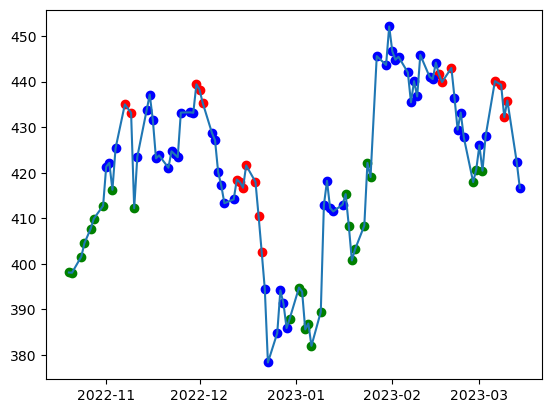

In [46]:
x=100
plt.plot(tata_ds.price[-x:])
plt.scatter(y=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==1],x=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==1].index,color='g')
plt.scatter(y=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==-1],x=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==-1].index,color='r')
plt.scatter(y=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==0],x=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==0].index,color='b')